### Run the clone github if you're running in colab environment
* git clone my project
* enter to project entry
* create .env file
* add your kaggle key and download dataset
* install the requirements

In [ ]:
!git clone https://github.com/larrychen20011120/Guided-DIP.git
%cd Guided-DIP

Cloning into 'Guided-DIP'...
remote: Enumerating objects: 143, done.
remote: Counting objects: 100% (143/143), done.
remote: Compressing objects: 100% (88/88), done.
remote: Total 143 (delta 53), reused 128 (delta 44), pack-reused 0
Receiving objects: 100% (143/143), 4.92 MiB | 8.20 MiB/s, done.
Resolving deltas: 100% (53/53), done.
/content/Guided-DIP


In [ ]:
!cp .env.example .env

In [ ]:
!pip install python-dotenv

### import packages

python original packages or the third-party packages

In [ ]:
import os
from dotenv import load_dotenv
import torch
import numpy as np
import matplotlib.pyplot as plt

personal defined modules in this project

In [ ]:
from utils.config_utils import load_ddpm_config, load_dip_config, load_img_config, load_guide_dip_config
from utils.plot_utils import plot_snapshots, plot_sequence, plot_psnr, plot_single_image
from utils.image_utils import load_image_to_tensor
from models.model import DDPM, DIP
from train.train_dip import train_dip

### load the config

In [ ]:
config_path = "config.yaml"
load_dotenv()
DATA_ENTRY = str(os.getenv("DATA_ENTRY"))

image_path = os.path.join(DATA_ENTRY, "Image_1.jpg")

In [ ]:
ddpm_config = load_ddpm_config(config_path)
dip_config = load_dip_config(config_path)
height, width = load_img_config(config_path)
guide_dip_config = load_guide_dip_config(config_path)

torch.manual_seed(dip_config["seed"])

define how to plot two line together

In [ ]:
def plot_twoline_comparisons(data1, data2, label1="PSNR", label2="MSE loss", title="Title"):


    fig, ax1 = plt.subplots(figsize=(12, 4))
    ax1.set_title(title)


    ax1.plot(range(len(data1)), data1, 'r-', label=label1)
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel(f'{label1} Value', color='r')
    ax1.tick_params(axis='y', labelcolor='r')

    ax2 = ax1.twinx()
    ax2.plot(range(len(data2)), data2, 'b-', label=label2)
    ax2.set_ylabel(f'{label2} Value', color='b')
    ax2.tick_params(axis='y', labelcolor='b')

    lines1 = ax1.get_lines()
    lines2 = ax2.get_lines()
    ax1.legend(lines1 + lines2, [l.get_label() for l in lines1 + lines2])
    fig.tight_layout()
    plt.show()

### Parameters

load dip training iterations

In [ ]:
num_steps = dip_config["num_steps"]

Given $count$ stages of noisy samples and assign different weights of training steps based on its level of noise

$$w_{i}=\frac{e^{-c\beta_{i}}}{e^{-c\beta_{1}}+e^{-c\beta_{2}}+...+e^{-c\beta_{count}}}$$
$$N_{i}=N*w_{i}$$

where $N$ is the total steps of Guided DIP, and $c$ is the scaled constant

In [ ]:
diffusion = DDPM(**ddpm_config)

if ddpm_config["scheduler"] == "linear":
    c = 250
else:
    c = 400

In [ ]:
timestamps = [ int(i) for i in np.linspace(guide_dip_config["start_t"], guide_dip_config["end_t"], guide_dip_config["count"]) ]
weights = [ np.exp(- c * diffusion.betas[t]) for t in timestamps ]
weights = weights / np.sum(weights)

print(f"each time in timestamps: {timestamps}")
print(f"each noise weights: {weights}")

steps = [ int(guide_dip_config["num_steps"] * w) for w in weights[:-1] ]
steps.append( guide_dip_config["num_steps"] - np.sum(steps) )

print(f"each noisy image train steps: {steps}")

each time in timestamps: [500, 475, 451, 427, 403, 378, 354, 330, 306, 282, 257, 233, 209, 185, 161, 136, 112, 88, 64, 40]
each noise weights: [0.02462843 0.02706958 0.02945766 0.03188642 0.03435207 0.03696605
 0.03952463 0.0421255  0.04477459 0.04748146 0.05036159 0.05319275
 0.05609338 0.05906764 0.06212845 0.06541802 0.0686768  0.07205322
 0.07555421 0.07918752]
each noisy image train steps: [49, 54, 58, 63, 68, 73, 79, 84, 89, 94, 100, 106, 112, 118, 124, 130, 137, 144, 151, 167]


### Train DIP with small noise

In [ ]:
clean_image = load_image_to_tensor(image_path, height, width)
target_image, _ = diffusion.forward_diffusion(clean_image, timestamps[-1])

model = DIP(dip_config["backbone_name"]).to(dip_config["device"])

losses, snapshots, psnrs = train_dip(model, target_image.to(dip_config["device"]), clean_image=clean_image, **dip_config)

  0%|          | 0/2000 [00:00<?, ?it/s]

plot some of snapshots through cutting in equal intervals

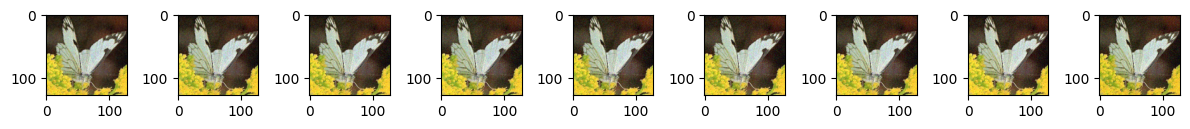

In [ ]:
indices = [ int(i) for i in torch.linspace(10, len(snapshots)-1, 10) ]
plot_sequence([ snapshots[i] for i in indices ])

plot the training process performance

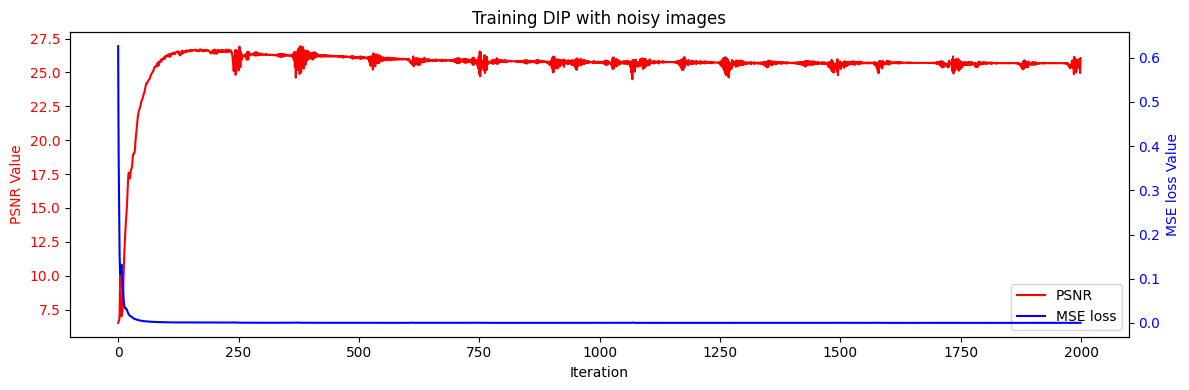

In [ ]:
plot_twoline_comparisons(psnrs, losses, title="Training DIP with noisy images")

plot the final image and its score

Best PSNR = 26.937792344004055 , and it's at the timestamp: 378
Final PSNR: 26.055270510528075
Final MSE LOSS: 9.363961726194248e-05


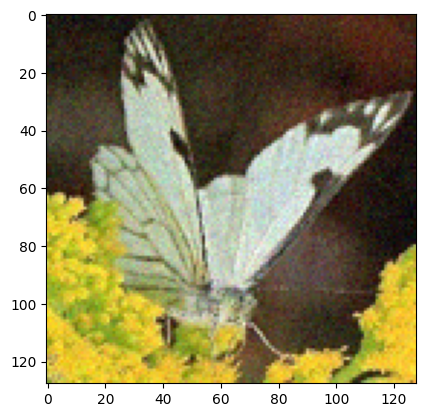

In [ ]:
print("Best PSNR =", np.max(psnrs), ", and it's at the timestamp:", np.argmax(psnrs))
print("Final PSNR:", psnrs[-1])
print("Final MSE LOSS:", losses[-1])

plot_single_image(snapshots[-1])

plot the best reconstruction

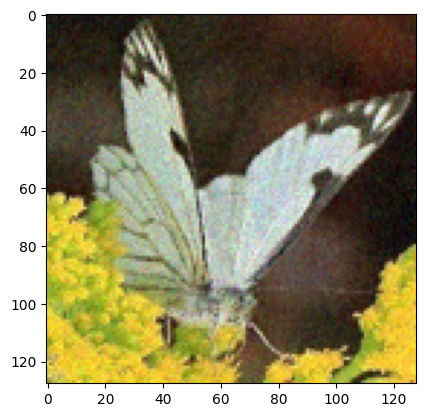

In [ ]:
plot_single_image(snapshots[np.argmax(psnrs)])

### Train DDPM Guided DIP

In [ ]:
clean_image = load_image_to_tensor(image_path, height, width)

diffusion = DDPM(**ddpm_config)
model = DIP(dip_config["backbone_name"]).to(dip_config["device"])

collects = []
losses = []
snapshots = []
psnrs = []

for t in range(len(timestamps)):

    target_image, _ = diffusion.forward_diffusion(clean_image, timestamps[t])
    collects.append(target_image)

    guide_dip_config["num_steps"] = steps[t]

    loss, snapshot, psnr = train_dip(model, target_image.to(dip_config["device"]), clean_image=clean_image, **guide_dip_config)
    losses.extend(loss)
    snapshots.extend(snapshot)
    psnrs.extend(psnr)

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/130 [00:00<?, ?it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

plot some of snapshots through cutting in equal intervals

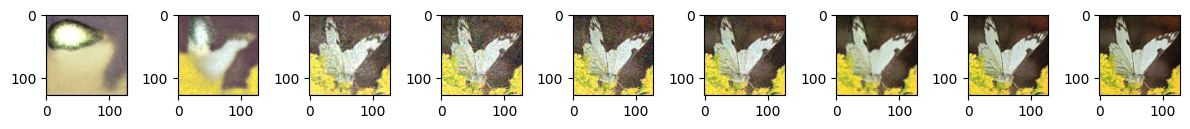

In [ ]:
indices = [ int(i) for i in torch.linspace(10, len(snapshots)-1, 10) ]
plot_sequence([ snapshots[i] for i in indices ])

plot the training process performance

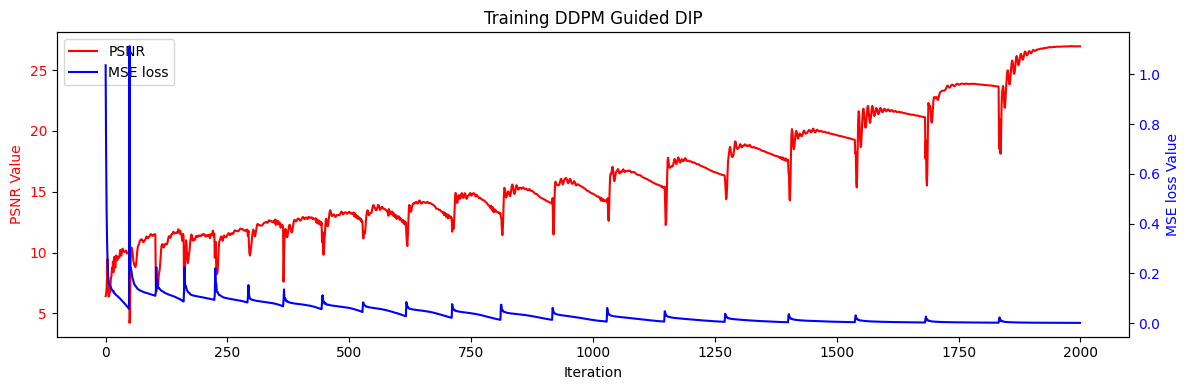

In [ ]:
plot_twoline_comparisons(psnrs, losses, title="Training DDPM Guided DIP")

plot the final image and its score

Best PSNR = 26.964241580952105 , and it's at the timestamp: 1981
Final PSNR: 26.947709267353485
Final MSE LOSS: 0.0009732317994348705


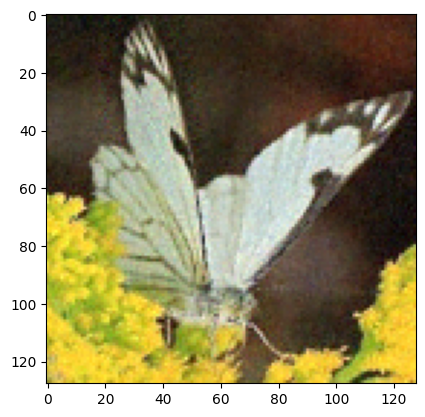

In [ ]:
print("Best PSNR =", np.max(psnrs), ", and it's at the timestamp:", np.argmax(psnrs))
print("Final PSNR:", psnrs[-1])
print("Final MSE LOSS:", losses[-1])

plot_single_image(snapshots[-1])

plot the best image

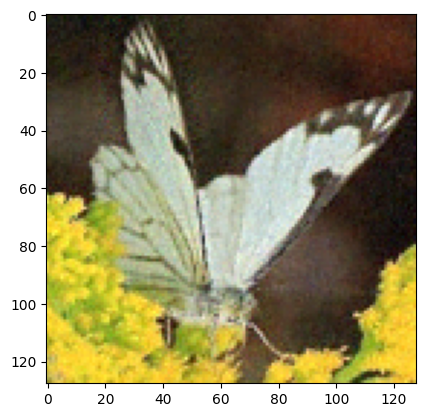

In [ ]:
plot_single_image(snapshots[np.argmax(psnrs)])